Select a model for stock price forecasting:
1. LSTM Model
2. GRU Model
3. Dense Neural Network
4. All Models


Enter the number of your choice:  4


You selected option 4
Epoch 1/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0541
Epoch 2/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012
Epoch 3/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012
Epoch 4/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012
Epoch 5/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0010
Epoch 6/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011
Epoch 7/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.5069e-04
Epoch 8/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.4812e-04
Epoch 9/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9764e-04
Epoch 10/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.5299e-04
Epoch 11/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.5420e-04
Epoch 12/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.2620e-04
Epoch 13/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 7.8473e-04
Epoch 14/40
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.0189e-04
Epoch 15/40
56/56

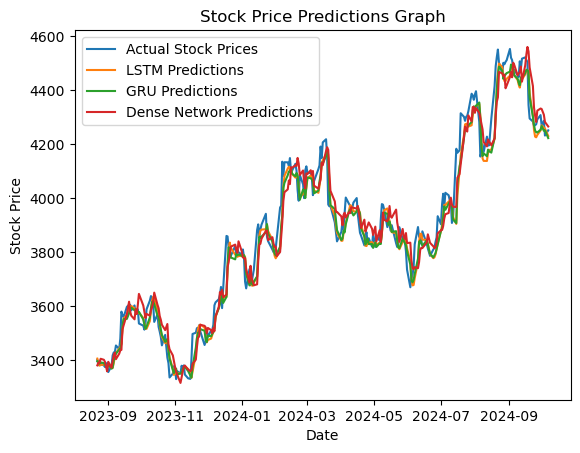

LSTM - MSE: 3856.0540, MAE: 45.3758
GRU - MSE: 3545.7650, MAE: 43.3487
Dense - MSE: 5108.9350, MAE: 54.1801

Latest predicted stock price by LSTM: 4231.51

Latest predicted stock price by GRU: 4223.46

Latest predicted stock price by Dense: 4266.50

The top-performing model is: GRU


In [10]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.src.models import Sequential
from keras.src.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

stock_data_file_path = "stock_date.xlsx"  # we can change file path/name

############## Load the stock data  ###################
def fetch_stock_dataset(file_path):
    stock_info = pd.read_excel(file_path)
    stock_info['Date'] = pd.to_datetime(stock_info['Date'])
    stock_info.set_index('Date', inplace=True)
    return stock_info[['Close']]

######################## This function is for generating training samples and labels ##############################
def create_training_sequences(data_stream, lookback_window):
    sequence_inputs, sequence_targets = [], []
    for idx in range(len(data_stream) - lookback_window - 1):
        sequence_inputs.append(data_stream[idx:(idx + lookback_window), 0])
        sequence_targets.append(data_stream[idx + lookback_window, 0])
    return np.array(sequence_inputs), np.array(sequence_targets)

####################### Function for LSTM model to construct and train ###########################
def build_lstm_architecture(train_features, train_targets, lookback_window):
    lstm_net = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback_window, 1)),
        LSTM(50, return_sequences=False), Dense(15), Dense(1)])
    lstm_net.compile(optimizer='adam', loss='mean_squared_error')
    lstm_net.fit(train_features, train_targets, batch_size=20, epochs=40, verbose=1)
    return lstm_net

####################### Function for GRU Model to construct and train ############################
def build_gru_architecture(train_features, train_targets, lookback_window):
    """

    :param train_features:
    :param train_targets:
    :param lookback_window:
    :return:
    """
    gru_net = Sequential([
        GRU(60, return_sequences=True, input_shape=(lookback_window, 1)),
        Dropout(0.2),
        GRU(60, return_sequences=False),
        Dense(30, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    gru_net.compile(optimizer='adam', loss='mean_squared_error')
    gru_net.fit(train_features, train_targets, batch_size=20, epochs=50, verbose=1)
    return gru_net

######################### Function for DNN model to construct and train ##########################
def build_dense_architecture(train_features, train_targets, lookback_window):
    reshaped_features = train_features.reshape(train_features.shape[0], lookback_window)
    dense_net = Sequential([
        Dense(60, input_dim=lookback_window, activation='relu'),
        Dense(30, activation='relu'), Dense(1)
    ])
    dense_net.compile(optimizer='adam', loss='mean_squared_error')
    dense_net.fit(reshaped_features, train_targets.reshape(-1, 1), batch_size=20, epochs=50, verbose=1)
    return dense_net

####################### This function is use for evaluating the Model ###############################
def assess_model_performance(model, test_features, actual_targets):
    pred_values = model.predict(test_features)
    pred_values = scaler.inverse_transform(pred_values)
    error_mse = mean_squared_error(actual_targets, pred_values)
    error_mae = mean_absolute_error(actual_targets, pred_values)
    return error_mse, error_mae, pred_values

############################## main function to execute the program ##########################
def execute_stock_prediction():
    # Load and normalize data
    stock_data = fetch_stock_dataset(stock_data_file_path)
    global scaler  # Make scaler global to use during evaluation process
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(stock_data)

    lookback_window = 100
    feature_sequences, target_values = create_training_sequences(scaled_prices, lookback_window)
    feature_sequences = feature_sequences.reshape(feature_sequences.shape[0], feature_sequences.shape[1], 1)

    ################# Split the data-set ######################
    split_index = int(len(feature_sequences) * 0.8)
    train_features, test_features = feature_sequences[:split_index], feature_sequences[split_index:]
    train_targets, test_targets = target_values[:split_index], target_values[split_index:]

    ######################### Taking User input to choose a model for prediction ########################
    while True:
        print("Select a model for stock price forecasting:")
        print("1. LSTM Model")
        print("2. GRU Model")
        print("3. Dense Neural Network")
        print("4. All Models")

        model_choice = input("Enter the number of your choice: ")
        if model_choice in ['1', '2', '3', '4']:
            print(f"You selected option {model_choice}")
            break
        else:
            print("Invalid choice. Please select again.")

    ########################### Creating Graph for Actual prices for comparing ########################
    original_targets = scaler.inverse_transform(test_targets.reshape(-1, 1))
    plt.plot(stock_data.index[-len(test_targets):], original_targets, label='Actual Stock Prices')

    ########################## Run predictions based on user's selection ###############################
    performance_metrics = {}
    latest_price_predictions = {}

    if model_choice in ['1', '4']:
        lstm_net = build_lstm_architecture(train_features, train_targets, lookback_window)
        lstm_mse, lstm_mae, lstm_preds = assess_model_performance(lstm_net, test_features, original_targets)
        plt.plot(stock_data.index[-len(test_targets):], lstm_preds, label='LSTM Predictions')
        performance_metrics['LSTM'] = (lstm_mse, lstm_mae)
        latest_price_predictions['LSTM'] = lstm_preds[-1][0]  # Store the latest prediction

    if model_choice in ['2', '4']:
        gru_net = build_gru_architecture(train_features, train_targets, lookback_window)
        gru_mse, gru_mae, gru_preds = assess_model_performance(gru_net, test_features, original_targets)
        plt.plot(stock_data.index[-len(test_targets):], gru_preds, label='GRU Predictions')
        performance_metrics['GRU'] = (gru_mse, gru_mae)
        latest_price_predictions['GRU'] = gru_preds[-1][0]  # Store the latest prediction

    if model_choice in ['3', '4']:
        dense_net = build_dense_architecture(train_features, train_targets, lookback_window)
        reshaped_test_features = test_features.reshape(test_features.shape[0], lookback_window)
        dense_mse, dense_mae, dense_preds = assess_model_performance(dense_net, reshaped_test_features, original_targets)
        plt.plot(stock_data.index[-len(test_targets):], dense_preds, label='Dense Network Predictions')
        performance_metrics['Dense'] = (dense_mse, dense_mae)
        latest_price_predictions['Dense'] = dense_preds[-1][0]  # Store the latest prediction

    ########################### Create plot graph predictions  ########################
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Predictions Graph')
    plt.legend()
    plt.show()

    #################### print the performance metrics #########################
    for architecture, (mse_val, mae_val) in performance_metrics.items():
        print(f"{architecture} - MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")

    ##################### print latest predicted stock price for each model ######################
    for model, price in latest_price_predictions.items():
        print(f"\nLatest predicted stock price by {model}: {price:.2f}")

    #################### Display best model only if all models (option: 4) are selected ###############
    if model_choice == '4':
        top_model = min(performance_metrics, key=lambda x: performance_metrics[x][0])
        print(f"\nThe top-performing model is: {top_model}")

if __name__ == "__main__":
    execute_stock_prediction()